# 금속 3D 프린팅 결함 검출 및 분류 - 연합학습 데모

이 노트북은 AprilGAN + CNN 파이프라인을 연합학습 프레임워크에서 시연합니다.

## 파이프라인 개요

1. **AprilGAN**: 제로샷 이상 탐지 (학습 불필요)
2. **CNN**: 결함 유형 분류 (연합학습)
3. **연합학습**: 여러 클라이언트가 가중치만 공유하여 협력 학습


## 1. 환경 설정 및 모듈 임포트


In [1]:
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import torch
import cv2

# 한글 폰트 설정 (Windows)
import matplotlib.font_manager as fm

# Windows에서 사용 가능한 한글 폰트 찾기
font_list = ['Malgun Gothic', 'NanumGothic', 'NanumBarunGothic', 'AppleGothic']
font_name = None

for font in font_list:
    try:
        # 폰트가 설치되어 있는지 확인
        font_path = fm.findfont(fm.FontProperties(family=font))
        if font_path:
            font_name = font
            break
    except:
        continue

if font_name:
    plt.rcParams['font.family'] = font_name
    plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지
    print(f"한글 폰트 설정 완료: {font_name}")
else:
    # 폰트를 찾지 못한 경우 경고만 출력
    print("⚠️ 한글 폰트를 찾을 수 없습니다. 한글이 깨질 수 있습니다.")
    print("💡 해결 방법: Windows에서 '맑은 고딕' 폰트가 설치되어 있는지 확인하세요.")

# 프로젝트 루트 경로 추가
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

# 모듈 임포트
from models.aprilgan import AprilGAN
from models.cnn import DefectClassifierCNN, create_cnn_model
from utils.data_loader import load_defect_data
from utils.bbox_utils import extract_bboxes_from_json
from federated.server import FederatedServer
from federated.client import FederatedClient

print("모듈 로드 완료")

한글 폰트 설정 완료: Malgun Gothic
모듈 로드 완료


## 2. 데이터 준비


In [2]:
# 데이터 디렉토리 설정
data_dir = Path("../data")

# 데이터 확인
image_files = list(data_dir.glob("*.jpg"))
print(f"총 이미지 수: {len(image_files)}")

if len(image_files) > 0:
    print(f"첫 번째 이미지: {image_files[0]}")
    
    # 샘플 이미지 확인
    img = cv2.imread(str(image_files[0]))
    if img is not None:
        print(f"이미지 크기: {img.shape}")
        
        # JSON 파일 확인
        json_file = image_files[0].with_suffix(".jpg.json")
        if json_file.exists():
            bboxes, defect_types = extract_bboxes_from_json(json_file)
            print(f"바운딩박스 수: {len(bboxes)}")
            print(f"결함 유형: {defect_types}")
            
print("\n💡 Non-IID 분배: 각 클라이언트가 서로 다른 결함 유형 분포를 가지도록 데이터가 분배됩니다.")


총 이미지 수: 9955
첫 번째 이미지: ..\data\20220106_1756_D160_layer0001_647372b64e2728e7ea257e4b.jpg
이미지 크기: (1080, 1920, 3)
바운딩박스 수: 1
결함 유형: ['Super Elevation']

💡 Non-IID 분배: 각 클라이언트가 서로 다른 결함 유형 분포를 가지도록 데이터가 분배됩니다.


## 3. AprilGAN 모델 초기화 (제로샷)


In [3]:
# AprilGAN 모델 초기화 (제로샷, 학습 불필요)
aprilgan = AprilGAN()

print("AprilGAN 모델 초기화 완료")
print("AprilGAN은 제로샷 모델로 추가 학습 없이 바로 사용 가능합니다")


[AprilGAN] 제로샷 모델 로드 완료 (시뮬레이션 모드)
AprilGAN 모델 초기화 완료
AprilGAN은 제로샷 모델로 추가 학습 없이 바로 사용 가능합니다


## 4. AprilGAN 이상 탐지 시연


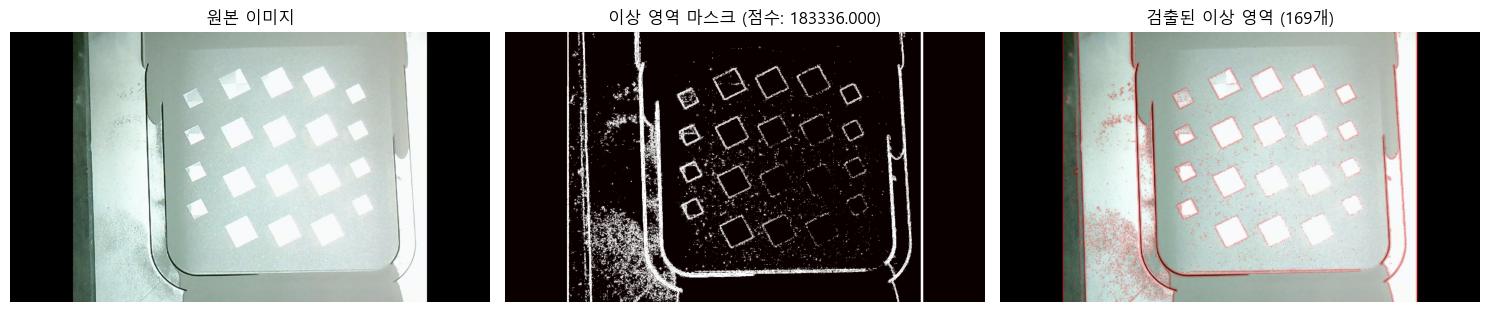

검출된 이상 영역 수: 169
  영역 1: (248, 0) - (258, 1080)
  영역 2: (290, 0) - (302, 55)
  영역 3: (290, 0) - (360, 1080)
  영역 4: (454, 0) - (1453, 1080)
  영역 5: (1514, 0) - (1629, 1080)
  영역 6: (1590, 0) - (1603, 8)
  영역 7: (1663, 0) - (1673, 1080)
  영역 8: (282, 83) - (294, 93)
  영역 9: (274, 86) - (285, 99)
  영역 10: (1214, 129) - (1286, 192)
  영역 11: (1000, 134) - (1113, 206)
  영역 12: (832, 142) - (970, 273)
  영역 13: (294, 149) - (302, 163)
  영역 14: (1187, 152) - (1211, 168)
  영역 15: (880, 155) - (893, 169)
  영역 16: (1166, 167) - (1214, 253)
  영역 17: (857, 171) - (871, 180)
  영역 18: (842, 174) - (857, 190)
  영역 19: (1113, 181) - (1126, 209)
  영역 20: (507, 199) - (524, 218)
  영역 21: (1012, 200) - (1032, 235)
  영역 22: (1339, 205) - (1428, 291)
  영역 23: (904, 206) - (939, 213)
  영역 24: (1275, 208) - (1303, 231)
  영역 25: (689, 221) - (777, 311)
  영역 26: (1104, 220) - (1136, 240)
  영역 27: (478, 223) - (494, 255)
  영역 28: (1025, 234) - (1104, 270)
  영역 29: (753, 242) - (766, 259)
  영역 30: (435, 245) - (4

In [4]:
# 샘플 이미지로 AprilGAN 테스트
if len(image_files) > 0:
    sample_image_path = image_files[0]
    
    # 이미지 로드
    image_bgr = cv2.imread(str(sample_image_path))
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    
    # AprilGAN으로 이상 탐지
    result = aprilgan.detect(image_rgb)
    
    # 결과 시각화
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # 원본 이미지
    axes[0].imshow(image_rgb)
    axes[0].set_title("원본 이미지")
    axes[0].axis('off')
    
    # 이상 마스크
    axes[1].imshow(result['anomaly_mask'], cmap='hot')
    axes[1].set_title(f"이상 영역 마스크 (점수: {result['anomaly_score']:.3f})")
    axes[1].axis('off')
    
    # 원본 + 이상 영역 오버레이
    overlay = image_rgb.copy()
    overlay[result['anomaly_mask'] == 1] = [255, 0, 0]  # 빨간색으로 표시
    blended = cv2.addWeighted(image_rgb, 0.7, overlay, 0.3, 0)
    axes[2].imshow(blended)
    axes[2].set_title(f"검출된 이상 영역 ({len(result['anomaly_regions'])}개)")
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"검출된 이상 영역 수: {len(result['anomaly_regions'])}")
    for i, region in enumerate(result['anomaly_regions']):
        print(f"  영역 {i+1}: ({region['x1']}, {region['y1']}) - ({region['x2']}, {region['y2']})")


## 5. CNN 모델 초기화 및 데이터 로딩


In [5]:
# CNN 모델 생성 및 Non-IID 데이터 로딩
from utils.client_data_loader import load_client_data

num_clients = 3
non_iid_alpha = 0.5  # Non-IID 정도 (0.1: 매우 편향, 1.0: 보통, 10.0: 균등)

try:
    # 클라이언트별 Non-IID 데이터 로드
    train_loaders, val_loaders, defect_type_to_idx = load_client_data(
        data_dir=data_dir,
        aprilgan_model=aprilgan,
        num_clients=num_clients,
        train_ratio=0.8,
        batch_size=16,
        patch_size=(224, 224),
        non_iid_alpha=non_iid_alpha,
        verbose=True
    )
    
    num_classes = len(defect_type_to_idx)
    print(f"\n결함 유형 수: {num_classes}")
    print(f"클라이언트별 데이터 로더 생성 완료: {len(train_loaders)}개")
    
    # CNN 모델 생성
    cnn_model = create_cnn_model(
        num_classes=num_classes,
        backbone='resnet18',
        pretrained=True
    )
    
    print(f"CNN 모델 생성 완료 (클래스 수: {num_classes})")
    
except Exception as e:
    print(f"데이터 로딩 오류: {e}")
    print("데모를 위해 더미 데이터 사용")
    num_classes = 5  # 기본값
    cnn_model = create_cnn_model(num_classes=num_classes)
    train_loaders = [None] * num_clients
    val_loaders = [None] * num_clients



[클라이언트별 Non-IID 데이터 로딩]
  ├─ 클라이언트 수: 3개
  ├─ Non-IID 정도 (alpha): 0.5
  └─ alpha 설명: 작을수록 편향됨 (0.1=매우편향, 1.0=보통, 10.0=균등)

[1단계] 전체 데이터 분석
  └─ 발견된 결함 유형: 7개

[2단계] Non-IID 분배 수행 중...

[Non-IID 분배] 데이터 분석 중...
  └─ 발견된 결함 유형: 6개
      - Fail: 1079개
      - Humping: 534개
      - Laser capture timing error: 318개
      - Recoater Streaking: 5593개
      - Recoater capture timing error: 159개
      - Super Elevation: 2272개

[Non-IID 분배] Dirichlet 분포로 클라이언트별 분배 (alpha=0.5)...

[Non-IID 분배] 분배 완료!
  └─ 클라이언트별 샘플 수:
      클라이언트 0: 908개
      클라이언트 1: 6927개
      클라이언트 2: 2120개

[Non-IID 분석] 클라이언트별 데이터 분포

[클라이언트 0]
  ├─ 총 샘플 수: 1389개
  └─ 결함 유형별 분포:
      Fail                            405개 ( 29.2%) ██████████████
      Super Elevation                 382개 ( 27.5%) █████████████
      Recoater Streaking              285개 ( 20.5%) ██████████
      Humping                         216개 ( 15.6%) ███████
      Recoater capture timing error    84개 (  6.0%) ███
      Laser capture timing error      

이상 영역 검출: 100%|██████████████████| 726/726 [00:54<00:00, 13.20image/s, 처리=726/726, 샘플=539]e/s]



[데이터 준비] ✅ 완료!
  ├─ 처리된 이미지: 726개
  ├─ 검출된 이상 영역: 133081개
  ├─ 매칭된 영역: 539개
  └─ 생성된 샘플: 539개


[데이터 준비] AprilGAN으로 이상 영역 검출 중...
  ├─ 총 이미지 수: 182개


이상 영역 검출: 100%|██████████████████| 182/182 [00:15<00:00, 11.89image/s, 처리=182/182, 샘플=134]e/s]



[데이터 준비] ✅ 완료!
  ├─ 처리된 이미지: 182개
  ├─ 검출된 이상 영역: 25634개
  ├─ 매칭된 영역: 134개
  └─ 생성된 샘플: 134개

    └─ 완료! (학습 샘플: 539개, 검증 샘플: 134개)

  [클라이언트 1] 데이터셋 생성 중...
    ├─ 학습용: 5541개
    └─ 검증용: 1386개

[데이터 준비] AprilGAN으로 이상 영역 검출 중...
  ├─ 총 이미지 수: 5541개


이상 영역 검출: 100%|█████████████| 5541/5541 [06:42<00:00, 13.78image/s, 처리=5541/5541, 샘플=3579]e/s]



[데이터 준비] ✅ 완료!
  ├─ 처리된 이미지: 5541개
  ├─ 검출된 이상 영역: 883769개
  ├─ 매칭된 영역: 3579개
  └─ 생성된 샘플: 3579개


[데이터 준비] AprilGAN으로 이상 영역 검출 중...
  ├─ 총 이미지 수: 1386개


이상 영역 검출: 100%|██████████████| 1386/1386 [01:42<00:00, 13.48image/s, 처리=1386/1386, 샘플=941]e/s]



[데이터 준비] ✅ 완료!
  ├─ 처리된 이미지: 1386개
  ├─ 검출된 이상 영역: 218914개
  ├─ 매칭된 영역: 941개
  └─ 생성된 샘플: 941개

    └─ 완료! (학습 샘플: 3579개, 검증 샘플: 941개)

  [클라이언트 2] 데이터셋 생성 중...
    ├─ 학습용: 1696개
    └─ 검증용: 424개

[데이터 준비] AprilGAN으로 이상 영역 검출 중...
  ├─ 총 이미지 수: 1696개


이상 영역 검출: 100%|█████████████| 1696/1696 [02:10<00:00, 12.97image/s, 처리=1696/1696, 샘플=1091]e/s]



[데이터 준비] ✅ 완료!
  ├─ 처리된 이미지: 1696개
  ├─ 검출된 이상 영역: 229824개
  ├─ 매칭된 영역: 1091개
  └─ 생성된 샘플: 1091개


[데이터 준비] AprilGAN으로 이상 영역 검출 중...
  ├─ 총 이미지 수: 424개


이상 영역 검출: 100%|██████████████████| 424/424 [00:36<00:00, 11.74image/s, 처리=424/424, 샘플=299]e/s]
d:\iot\GAN-CNN\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\iot\GAN-CNN\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



[데이터 준비] ✅ 완료!
  ├─ 처리된 이미지: 424개
  ├─ 검출된 이상 영역: 70782개
  ├─ 매칭된 영역: 299개
  └─ 생성된 샘플: 299개

    └─ 완료! (학습 샘플: 1091개, 검증 샘플: 299개)

[클라이언트별 Non-IID 데이터 로딩] ✅ 완료!


결함 유형 수: 7
클라이언트별 데이터 로더 생성 완료: 3개
CNN 모델 생성 완료 (클래스 수: 7)


## 6. 연합학습 서버 시작


In [6]:
# 연합학습 서버 생성
server = FederatedServer(
    port=5000,
    num_clients=3,
    min_clients=2
)

# 초기 가중치 설정
initial_weights = cnn_model.state_dict()
server.set_initial_weights(initial_weights)

print("연합학습 서버 준비 완료")
print("서버는 별도 스레드에서 실행됩니다")


[서버] 초기 가중치 설정 완료
연합학습 서버 준비 완료
서버는 별도 스레드에서 실행됩니다


In [7]:
# 서버를 백그라운드에서 시작
import threading
import time

server_thread = threading.Thread(
    target=server.start,
    kwargs={'host': 'localhost', 'debug': False},
    daemon=True
)
server_thread.start()

# 서버가 시작될 때까지 대기
time.sleep(2)

print("서버 시작 완료")


[서버] 연합학습 서버 시작 (포트: 5000)
 * Serving Flask app 'federated.server'
 * Debug mode: off


 * Running on http://localhost:5000
Press CTRL+C to quit


서버 시작 완료


## 7. 연합학습 클라이언트 생성 및 학습


In [8]:
# 여러 클라이언트 생성 (시뮬레이션)
clients = []
num_clients = 3

for client_id in range(num_clients):
    client = FederatedClient(
        client_id=client_id,
        server_url='http://localhost:5000',
        model=create_cnn_model(num_classes=num_classes)
    )
    clients.append(client)
    print(f"클라이언트 {client_id} 생성 완료")


클라이언트 0 생성 완료
클라이언트 1 생성 완료
클라이언트 2 생성 완료


## 8. 연합학습 라운드 실행


In [9]:
# 연합학습 라운드 실행
num_rounds = 3

for round_num in range(num_rounds):
    print(f"\n{'='*60}")
    print(f"라운드 {round_num + 1}/{num_rounds}")
    print(f"{'='*60}")
    
    # 1. 각 클라이언트가 서버에서 최신 가중치 가져오기
    print("\n[1단계] 클라이언트가 서버에서 가중치 수신")
    for client in clients:
        client.fetch_aggregated_weights(round_num)
    
    # 2. 각 클라이언트가 로컬 데이터로 학습 (Non-IID 데이터 사용)
    print("\n[2단계] 클라이언트 로컬 학습 (Non-IID 데이터)")
    if 'train_loaders' in locals() and train_loaders[0] is not None:
        # 실제 Non-IID 데이터가 있는 경우
        for client in clients:
            client_train_loader = train_loaders[client.client_id]
            stats = client.train_local(client_train_loader, epochs=1, learning_rate=0.001)
            print(f"  클라이언트 {client.client_id}: Loss={stats['loss']:.4f}, "
                  f"Accuracy={stats['accuracy']:.4f}, Samples={stats['samples']}")
    else:
        # 더미 학습 (실제 구현에서는 실제 데이터 사용)
        print("  더미 학습 모드 (실제 데이터 필요)")
    
    # 3. 각 클라이언트가 학습된 가중치를 서버로 전송
    print("\n[3단계] 클라이언트가 가중치를 서버로 전송")
    for client in clients:
        # 실제 데이터 크기 사용
        if 'train_loaders' in locals() and train_loaders[client.client_id] is not None:
            data_size = len(train_loaders[client.client_id].dataset)
        else:
            data_size = 100  # 더미 값
        client.upload_weights(round_num, data_size)
    
    # 4. 서버가 가중치 집계 (자동으로 수행됨)
    print("\n[4단계] 서버가 가중치 집계")
    time.sleep(1)  # 서버 처리 대기
    
    aggregated_weights = server.get_aggregated_weights()
    if aggregated_weights is not None:
        print(f"  가중치 집계 완료 (라운드 {server.current_round})")
    else:
        print("  아직 집계되지 않음 (더 많은 클라이언트 필요)")
    
    print(f"\n라운드 {round_num + 1} 완료")



라운드 1/3

[1단계] 클라이언트가 서버에서 가중치 수신
[클라이언트 0] 서버에서 가중치 요청 중...


127.0.0.1 - - [22/Nov/2025 00:23:38] "GET /get_weights HTTP/1.1" 200 -


[클라이언트 0] ✅ 집계된 가중치 수신 완료!
  ├─ 서버 라운드: 0
  └─ 전송 형식: binary_compressed
[클라이언트 1] 서버에서 가중치 요청 중...


127.0.0.1 - - [22/Nov/2025 00:23:42] "GET /get_weights HTTP/1.1" 200 -


[클라이언트 1] ✅ 집계된 가중치 수신 완료!
  ├─ 서버 라운드: 0
  └─ 전송 형식: binary_compressed
[클라이언트 2] 서버에서 가중치 요청 중...


127.0.0.1 - - [22/Nov/2025 00:23:46] "GET /get_weights HTTP/1.1" 200 -


[클라이언트 2] ✅ 집계된 가중치 수신 완료!
  ├─ 서버 라운드: 0
  └─ 전송 형식: binary_compressed

[2단계] 클라이언트 로컬 학습 (Non-IID 데이터)

[클라이언트 0] 일반 학습 모드 시작
  - 총 에폭: 1
  - 학습률: 0.001
  - 배치 수: 34
  - 디바이스: cuda



[클라이언트 0] Epoch 1/1: 100%|█| 34/34 [00:09<00:00,  3.62batch/s, Loss=0.5352, Acc=0.8256, Batch=3



[클라이언트 0] Epoch 1/1 완료
  ├─ 평균 손실: 0.535170
  ├─ 정확도: 0.8256 (445/539)
  └─ 처리 샘플 수: 539개

[클라이언트 0] 학습 완료!
  ├─ 최종 손실: 0.535170
  ├─ 최종 정확도: 0.8256
  └─ 총 샘플 수: 539개

  클라이언트 0: Loss=0.5352, Accuracy=0.8256, Samples=539

[클라이언트 1] 일반 학습 모드 시작
  - 총 에폭: 1
  - 학습률: 0.001
  - 배치 수: 224
  - 디바이스: cuda



[클라이언트 1] Epoch 1/1: 100%|█| 224/224 [00:35<00:00,  6.36batch/s, Loss=0.3039, Acc=0.9081, Batch



[클라이언트 1] Epoch 1/1 완료
  ├─ 평균 손실: 0.303884
  ├─ 정확도: 0.9081 (3250/3579)
  └─ 처리 샘플 수: 3579개

[클라이언트 1] 학습 완료!
  ├─ 최종 손실: 0.303884
  ├─ 최종 정확도: 0.9081
  └─ 총 샘플 수: 3579개

  클라이언트 1: Loss=0.3039, Accuracy=0.9081, Samples=3579

[클라이언트 2] 일반 학습 모드 시작
  - 총 에폭: 1
  - 학습률: 0.001
  - 배치 수: 69
  - 디바이스: cuda



[클라이언트 2] Epoch 1/1: 100%|█| 69/69 [00:05<00:00, 12.20batch/s, Loss=0.3572, Acc=0.9019, Batch=6



[클라이언트 2] Epoch 1/1 완료
  ├─ 평균 손실: 0.357247
  ├─ 정확도: 0.9019 (984/1091)
  └─ 처리 샘플 수: 1091개

[클라이언트 2] 학습 완료!
  ├─ 최종 손실: 0.357247
  ├─ 최종 정확도: 0.9019
  └─ 총 샘플 수: 1091개

  클라이언트 2: Loss=0.3572, Accuracy=0.9019, Samples=1091

[3단계] 클라이언트가 가중치를 서버로 전송
[클라이언트 0] 가중치 업로드 준비 중...
  ├─ 총 파라미터 수: 11,319,259개
  ├─ 예상 크기: 43.18 MB
  └─ 데이터 크기: 539개 샘플
  └─ 서버로 전송 중... (http://localhost:5000)


127.0.0.1 - - [22/Nov/2025 00:25:00] "POST /upload_weights HTTP/1.1" 200 -


[서버] ✅ 클라이언트 0로부터 가중치 수신
  ├─ 라운드: 0
  ├─ 파라미터 수: 11,319,259개
  ├─ 데이터 크기: 539개 샘플
  └─ 수신된 클라이언트: 1/2
[클라이언트 0] ✅ 가중치 업로드 성공!
  └─ 서버 수신 클라이언트: 1/2
[클라이언트 1] 가중치 업로드 준비 중...
  ├─ 총 파라미터 수: 11,319,259개
  ├─ 예상 크기: 43.18 MB
  └─ 데이터 크기: 3579개 샘플
  └─ 서버로 전송 중... (http://localhost:5000)
[서버] ✅ 클라이언트 1로부터 가중치 수신
  ├─ 라운드: 0
  ├─ 파라미터 수: 11,319,259개
  ├─ 데이터 크기: 3579개 샘플
  └─ 수신된 클라이언트: 2/2

[서버] 가중치 집계 시작
  ├─ 참여 클라이언트 수: 2개
  ├─ 최소 요구 클라이언트: 2개
  │  └─ 클라이언트 0: 539개 샘플
  │  └─ 클라이언트 1: 3579개 샘플
  ├─ 총 데이터 크기: 4118개 샘플
  ├─ 가중치 분포:
  │  └─ 클라이언트 0: 0.1309 (539개)
  │  └─ 클라이언트 1: 0.8691 (3579개)
  └─ Federated Averaging 수행 중...

[서버] ✅ 가중치 집계 완료!
  ├─ 라운드: 1
  ├─ 총 파라미터 수: 11,319,259개
  └─ 집계 방식: Federated Averaging (가중 평균)



127.0.0.1 - - [22/Nov/2025 00:25:21] "POST /upload_weights HTTP/1.1" 200 -


[클라이언트 1] ✅ 가중치 업로드 성공!
  └─ 서버 수신 클라이언트: 2/2
[클라이언트 2] 가중치 업로드 준비 중...
  ├─ 총 파라미터 수: 11,319,259개
  ├─ 예상 크기: 43.18 MB
  └─ 데이터 크기: 1091개 샘플
  └─ 서버로 전송 중... (http://localhost:5000)


127.0.0.1 - - [22/Nov/2025 00:25:41] "POST /upload_weights HTTP/1.1" 200 -


[서버] ✅ 클라이언트 2로부터 가중치 수신
  ├─ 라운드: 0
  ├─ 파라미터 수: 11,319,259개
  ├─ 데이터 크기: 1091개 샘플
  └─ 수신된 클라이언트: 1/2
[클라이언트 2] ✅ 가중치 업로드 성공!
  └─ 서버 수신 클라이언트: 1/2

[4단계] 서버가 가중치 집계
  가중치 집계 완료 (라운드 1)

라운드 1 완료

라운드 2/3

[1단계] 클라이언트가 서버에서 가중치 수신
[클라이언트 0] 서버에서 가중치 요청 중...


127.0.0.1 - - [22/Nov/2025 00:25:46] "GET /get_weights HTTP/1.1" 200 -


[클라이언트 0] ✅ 집계된 가중치 수신 완료!
  ├─ 서버 라운드: 1
  └─ 전송 형식: binary_compressed
[클라이언트 1] 서버에서 가중치 요청 중...


127.0.0.1 - - [22/Nov/2025 00:25:51] "GET /get_weights HTTP/1.1" 200 -


[클라이언트 1] ✅ 집계된 가중치 수신 완료!
  ├─ 서버 라운드: 1
  └─ 전송 형식: binary_compressed
[클라이언트 2] 서버에서 가중치 요청 중...


127.0.0.1 - - [22/Nov/2025 00:25:55] "GET /get_weights HTTP/1.1" 200 -


[클라이언트 2] ✅ 집계된 가중치 수신 완료!
  ├─ 서버 라운드: 1
  └─ 전송 형식: binary_compressed

[2단계] 클라이언트 로컬 학습 (Non-IID 데이터)

[클라이언트 0] 일반 학습 모드 시작
  - 총 에폭: 1
  - 학습률: 0.001
  - 배치 수: 34
  - 디바이스: cuda



[클라이언트 0] Epoch 1/1: 100%|█| 34/34 [00:02<00:00, 12.44batch/s, Loss=0.5383, Acc=0.8627, Batch=3



[클라이언트 0] Epoch 1/1 완료
  ├─ 평균 손실: 0.538294
  ├─ 정확도: 0.8627 (465/539)
  └─ 처리 샘플 수: 539개

[클라이언트 0] 학습 완료!
  ├─ 최종 손실: 0.538294
  ├─ 최종 정확도: 0.8627
  └─ 총 샘플 수: 539개

  클라이언트 0: Loss=0.5383, Accuracy=0.8627, Samples=539

[클라이언트 1] 일반 학습 모드 시작
  - 총 에폭: 1
  - 학습률: 0.001
  - 배치 수: 224
  - 디바이스: cuda



[클라이언트 1] Epoch 1/1: 100%|█| 224/224 [00:18<00:00, 12.05batch/s, Loss=0.2279, Acc=0.9371, Batch



[클라이언트 1] Epoch 1/1 완료
  ├─ 평균 손실: 0.227882
  ├─ 정확도: 0.9371 (3354/3579)
  └─ 처리 샘플 수: 3579개

[클라이언트 1] 학습 완료!
  ├─ 최종 손실: 0.227882
  ├─ 최종 정확도: 0.9371
  └─ 총 샘플 수: 3579개

  클라이언트 1: Loss=0.2279, Accuracy=0.9371, Samples=3579

[클라이언트 2] 일반 학습 모드 시작
  - 총 에폭: 1
  - 학습률: 0.001
  - 배치 수: 69
  - 디바이스: cuda



[클라이언트 2] Epoch 1/1: 100%|█| 69/69 [00:05<00:00, 11.69batch/s, Loss=0.2029, Acc=0.9459, Batch=6



[클라이언트 2] Epoch 1/1 완료
  ├─ 평균 손실: 0.202933
  ├─ 정확도: 0.9459 (1032/1091)
  └─ 처리 샘플 수: 1091개

[클라이언트 2] 학습 완료!
  ├─ 최종 손실: 0.202933
  ├─ 최종 정확도: 0.9459
  └─ 총 샘플 수: 1091개

  클라이언트 2: Loss=0.2029, Accuracy=0.9459, Samples=1091

[3단계] 클라이언트가 가중치를 서버로 전송
[클라이언트 0] 가중치 업로드 준비 중...
  ├─ 총 파라미터 수: 11,319,259개
  ├─ 예상 크기: 43.18 MB
  └─ 데이터 크기: 539개 샘플
  └─ 서버로 전송 중... (http://localhost:5000)
[서버] ✅ 클라이언트 0로부터 가중치 수신
  ├─ 라운드: 1
  ├─ 파라미터 수: 11,319,259개
  ├─ 데이터 크기: 539개 샘플
  └─ 수신된 클라이언트: 2/2

[서버] 가중치 집계 시작
  ├─ 참여 클라이언트 수: 2개
  ├─ 최소 요구 클라이언트: 2개
  │  └─ 클라이언트 2: 1091개 샘플
  │  └─ 클라이언트 0: 539개 샘플
  ├─ 총 데이터 크기: 1630개 샘플
  ├─ 가중치 분포:
  │  └─ 클라이언트 2: 0.6693 (1091개)
  │  └─ 클라이언트 0: 0.3307 (539개)
  └─ Federated Averaging 수행 중...

[서버] ✅ 가중치 집계 완료!
  ├─ 라운드: 2
  ├─ 총 파라미터 수: 11,319,259개
  └─ 집계 방식: Federated Averaging (가중 평균)



127.0.0.1 - - [22/Nov/2025 00:26:44] "POST /upload_weights HTTP/1.1" 200 -


[클라이언트 0] ✅ 가중치 업로드 성공!
  └─ 서버 수신 클라이언트: 2/2
[클라이언트 1] 가중치 업로드 준비 중...
  ├─ 총 파라미터 수: 11,319,259개
  ├─ 예상 크기: 43.18 MB
  └─ 데이터 크기: 3579개 샘플
  └─ 서버로 전송 중... (http://localhost:5000)
[서버] ✅ 클라이언트 1로부터 가중치 수신
  ├─ 라운드: 1
  ├─ 파라미터 수: 11,319,259개
  ├─ 데이터 크기: 3579개 샘플
  └─ 수신된 클라이언트: 1/2


127.0.0.1 - - [22/Nov/2025 00:27:04] "POST /upload_weights HTTP/1.1" 200 -


[클라이언트 1] ✅ 가중치 업로드 성공!
  └─ 서버 수신 클라이언트: 1/2
[클라이언트 2] 가중치 업로드 준비 중...
  ├─ 총 파라미터 수: 11,319,259개
  ├─ 예상 크기: 43.18 MB
  └─ 데이터 크기: 1091개 샘플
  └─ 서버로 전송 중... (http://localhost:5000)
[서버] ✅ 클라이언트 2로부터 가중치 수신
  ├─ 라운드: 1
  ├─ 파라미터 수: 11,319,259개
  ├─ 데이터 크기: 1091개 샘플
  └─ 수신된 클라이언트: 2/2

[서버] 가중치 집계 시작
  ├─ 참여 클라이언트 수: 2개
  ├─ 최소 요구 클라이언트: 2개
  │  └─ 클라이언트 1: 3579개 샘플
  │  └─ 클라이언트 2: 1091개 샘플
  ├─ 총 데이터 크기: 4670개 샘플
  ├─ 가중치 분포:
  │  └─ 클라이언트 1: 0.7664 (3579개)
  │  └─ 클라이언트 2: 0.2336 (1091개)
  └─ Federated Averaging 수행 중...

[서버] ✅ 가중치 집계 완료!
  ├─ 라운드: 3
  ├─ 총 파라미터 수: 11,319,259개
  └─ 집계 방식: Federated Averaging (가중 평균)



127.0.0.1 - - [22/Nov/2025 00:27:25] "POST /upload_weights HTTP/1.1" 200 -


[클라이언트 2] ✅ 가중치 업로드 성공!
  └─ 서버 수신 클라이언트: 2/2

[4단계] 서버가 가중치 집계
  가중치 집계 완료 (라운드 3)

라운드 2 완료

라운드 3/3

[1단계] 클라이언트가 서버에서 가중치 수신
[클라이언트 0] 서버에서 가중치 요청 중...


127.0.0.1 - - [22/Nov/2025 00:27:30] "GET /get_weights HTTP/1.1" 200 -


[클라이언트 0] ✅ 집계된 가중치 수신 완료!
  ├─ 서버 라운드: 3
  └─ 전송 형식: binary_compressed
[클라이언트 1] 서버에서 가중치 요청 중...


127.0.0.1 - - [22/Nov/2025 00:27:35] "GET /get_weights HTTP/1.1" 200 -


[클라이언트 1] ✅ 집계된 가중치 수신 완료!
  ├─ 서버 라운드: 3
  └─ 전송 형식: binary_compressed
[클라이언트 2] 서버에서 가중치 요청 중...


127.0.0.1 - - [22/Nov/2025 00:27:39] "GET /get_weights HTTP/1.1" 200 -


[클라이언트 2] ✅ 집계된 가중치 수신 완료!
  ├─ 서버 라운드: 3
  └─ 전송 형식: binary_compressed

[2단계] 클라이언트 로컬 학습 (Non-IID 데이터)

[클라이언트 0] 일반 학습 모드 시작
  - 총 에폭: 1
  - 학습률: 0.001
  - 배치 수: 34
  - 디바이스: cuda



[클라이언트 0] Epoch 1/1: 100%|█| 34/34 [00:02<00:00, 12.70batch/s, Loss=0.4804, Acc=0.8831, Batch=3



[클라이언트 0] Epoch 1/1 완료
  ├─ 평균 손실: 0.480447
  ├─ 정확도: 0.8831 (476/539)
  └─ 처리 샘플 수: 539개

[클라이언트 0] 학습 완료!
  ├─ 최종 손실: 0.480447
  ├─ 최종 정확도: 0.8831
  └─ 총 샘플 수: 539개

  클라이언트 0: Loss=0.4804, Accuracy=0.8831, Samples=539

[클라이언트 1] 일반 학습 모드 시작
  - 총 에폭: 1
  - 학습률: 0.001
  - 배치 수: 224
  - 디바이스: cuda



[클라이언트 1] Epoch 1/1: 100%|█| 224/224 [00:18<00:00, 12.04batch/s, Loss=0.2156, Acc=0.9452, Batch



[클라이언트 1] Epoch 1/1 완료
  ├─ 평균 손실: 0.215571
  ├─ 정확도: 0.9452 (3383/3579)
  └─ 처리 샘플 수: 3579개

[클라이언트 1] 학습 완료!
  ├─ 최종 손실: 0.215571
  ├─ 최종 정확도: 0.9452
  └─ 총 샘플 수: 3579개

  클라이언트 1: Loss=0.2156, Accuracy=0.9452, Samples=3579

[클라이언트 2] 일반 학습 모드 시작
  - 총 에폭: 1
  - 학습률: 0.001
  - 배치 수: 69
  - 디바이스: cuda



[클라이언트 2] Epoch 1/1: 100%|█| 69/69 [00:05<00:00, 12.05batch/s, Loss=0.1158, Acc=0.9670, Batch=6



[클라이언트 2] Epoch 1/1 완료
  ├─ 평균 손실: 0.115775
  ├─ 정확도: 0.9670 (1055/1091)
  └─ 처리 샘플 수: 1091개

[클라이언트 2] 학습 완료!
  ├─ 최종 손실: 0.115775
  ├─ 최종 정확도: 0.9670
  └─ 총 샘플 수: 1091개

  클라이언트 2: Loss=0.1158, Accuracy=0.9670, Samples=1091

[3단계] 클라이언트가 가중치를 서버로 전송
[클라이언트 0] 가중치 업로드 준비 중...
  ├─ 총 파라미터 수: 11,319,259개
  ├─ 예상 크기: 43.18 MB
  └─ 데이터 크기: 539개 샘플
  └─ 서버로 전송 중... (http://localhost:5000)
[서버] ✅ 클라이언트 0로부터 가중치 수신
  ├─ 라운드: 2
  ├─ 파라미터 수: 11,319,259개
  ├─ 데이터 크기: 539개 샘플
  └─ 수신된 클라이언트: 1/2


127.0.0.1 - - [22/Nov/2025 00:28:28] "POST /upload_weights HTTP/1.1" 200 -


[클라이언트 0] ✅ 가중치 업로드 성공!
  └─ 서버 수신 클라이언트: 1/2
[클라이언트 1] 가중치 업로드 준비 중...
  ├─ 총 파라미터 수: 11,319,259개
  ├─ 예상 크기: 43.18 MB
  └─ 데이터 크기: 3579개 샘플
  └─ 서버로 전송 중... (http://localhost:5000)
[서버] ✅ 클라이언트 1로부터 가중치 수신
  ├─ 라운드: 2
  ├─ 파라미터 수: 11,319,259개
  ├─ 데이터 크기: 3579개 샘플
  └─ 수신된 클라이언트: 2/2

[서버] 가중치 집계 시작
  ├─ 참여 클라이언트 수: 2개
  ├─ 최소 요구 클라이언트: 2개
  │  └─ 클라이언트 0: 539개 샘플
  │  └─ 클라이언트 1: 3579개 샘플
  ├─ 총 데이터 크기: 4118개 샘플
  ├─ 가중치 분포:
  │  └─ 클라이언트 0: 0.1309 (539개)
  │  └─ 클라이언트 1: 0.8691 (3579개)
  └─ Federated Averaging 수행 중...

[서버] ✅ 가중치 집계 완료!
  ├─ 라운드: 4
  ├─ 총 파라미터 수: 11,319,259개
  └─ 집계 방식: Federated Averaging (가중 평균)



127.0.0.1 - - [22/Nov/2025 00:28:48] "POST /upload_weights HTTP/1.1" 200 -


[클라이언트 1] ✅ 가중치 업로드 성공!
  └─ 서버 수신 클라이언트: 2/2
[클라이언트 2] 가중치 업로드 준비 중...
  ├─ 총 파라미터 수: 11,319,259개
  ├─ 예상 크기: 43.18 MB
  └─ 데이터 크기: 1091개 샘플
  └─ 서버로 전송 중... (http://localhost:5000)


127.0.0.1 - - [22/Nov/2025 00:29:08] "POST /upload_weights HTTP/1.1" 200 -


[서버] ✅ 클라이언트 2로부터 가중치 수신
  ├─ 라운드: 2
  ├─ 파라미터 수: 11,319,259개
  ├─ 데이터 크기: 1091개 샘플
  └─ 수신된 클라이언트: 1/2
[클라이언트 2] ✅ 가중치 업로드 성공!
  └─ 서버 수신 클라이언트: 1/2

[4단계] 서버가 가중치 집계
  가중치 집계 완료 (라운드 4)

라운드 3 완료


## 9. 최종 모델 평가


In [10]:
# 최종 가중치로 모델 업데이트
final_weights = server.get_aggregated_weights()
if final_weights is not None:
    cnn_model.load_state_dict(final_weights)
    print("최종 집계된 가중치로 모델 업데이트 완료")
    
    # 평가 (실제 데이터가 있는 경우)
    if 'val_loaders' in locals() and val_loaders[0] is not None:
        print("\n[최종 평가] 모든 클라이언트의 검증 데이터로 평가")
        cnn_model.eval()
        
        total_correct = 0
        total_samples = 0
        
        # 모든 클라이언트의 검증 데이터로 평가
        for client_id, val_loader in enumerate(val_loaders):
            client_correct = 0
            client_samples = 0
            
            with torch.no_grad():
                for batch in val_loader:
                    images = batch['image']
                    labels = batch['label']
                    
                    outputs = cnn_model(images)
                    _, predicted = torch.max(outputs, 1)
                    
                    batch_size = labels.size(0)
                    client_samples += batch_size
                    client_correct += (predicted == labels).sum().item()
            
            client_accuracy = client_correct / client_samples if client_samples > 0 else 0.0
            print(f"  클라이언트 {client_id}: {client_accuracy:.4f} ({client_correct}/{client_samples})")
            
            total_samples += client_samples
            total_correct += client_correct
        
        overall_accuracy = total_correct / total_samples if total_samples > 0 else 0.0
        print(f"\n전체 모델 정확도: {overall_accuracy:.4f} ({total_correct}/{total_samples})")
    else:
        print("평가를 위해 실제 데이터가 필요합니다")


최종 집계된 가중치로 모델 업데이트 완료

[최종 평가] 모든 클라이언트의 검증 데이터로 평가
  클라이언트 0: 0.5597 (75/134)
  클라이언트 1: 0.9373 (882/941)
  클라이언트 2: 0.9900 (296/299)

전체 모델 정확도: 0.9119 (1253/1374)


## 10. 전체 파이프라인 요약

### 파이프라인 흐름:

```
원본 이미지
    ↓
[AprilGAN] 제로샷 이상 탐지 (학습 불필요)
    ↓
이상 영역 마스크/좌표
    ↓
[CNN] 결함 유형 분류 (연합학습)
    ↓
결함 유형 ("Super Elevation", "Crack", etc.)
```

### 연합학습 구조:

1. **AprilGAN**: 제로샷 모델로 모든 클라이언트에서 동일하게 사용
2. **CNN**: 각 클라이언트가 로컬 데이터로 학습
3. **가중치 전송**: CNN 가중치만 서버로 전송 (데이터는 전송 안 함)
4. **서버 집계**: Federated Averaging으로 가중치 평균화
5. **가중치 배포**: 평균화된 가중치를 모든 클라이언트에 배포

### 핵심 원칙:

- ✅ **데이터 프라이버시**: 원본 데이터는 절대 공유하지 않음
- ✅ **가중치만 전송**: 학습된 모델 가중치만 서버로 전송
- ✅ **서버 집계**: Federated Averaging으로 협력 학습
- ✅ **제로샷 활용**: AprilGAN은 추가 학습 없이 바로 사용
